> # **Configuration**


In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [ ]:
## Set The Path ##
%cd '/content/mydrive/MyDrive/MRI_Missing_Modality'

/content/mydrive/.shortcut-targets-by-id/1u1pCs1kaQnF4IoCddl0Yyil3Tjg83D1b/MRI_Missing_Modality


In [ ]:
!pip install nibabel

In [ ]:
!pip install torch-xla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.4/120.4 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: uritemplate
    Found existing installation: uritemplate 4.1.1
    Uninstalling uritemplate-4.1.1:
      Successfully uninstalled uritemplate-4.1.1
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 2.19.2
    Uninstalling google-api-core-2.19.2:
      Successfully uninstalled google-api-core-2.19.2
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.137.0
    Uninstalling google-api-python-client-2.137.0:
      Successfully uninstalled google-api-python-client-2.137.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency confl

> # **Load dataset (BraTS2020)**

In [ ]:
import os, cv2
import nibabel as nib
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# مسیر داده‌ها و فایل اکسل
data_path = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
csv_path = os.path.join(data_path, 'name_mapping.csv')

# بارگذاری فایل اکسل
try:
    name_mapping = pd.read_csv(csv_path)
    # Shuffle the data
    # name_mapping = name_mapping.sample(frac=1).reset_index(drop=True)
    name_mapping = name_mapping[:len(name_mapping)]

except FileNotFoundError:
    print(f"Error: CSV file '{csv_path}' not found.")
    exit(1)

# تابع بارگذاری داده‌های MRI
def load_mri(file_path):
    try:
        img = nib.load(file_path)
        return img.get_fdata()
    except FileNotFoundError:
        print(f"Error: MRI file '{file_path}' not found.")
        return None
    except Exception as e:
        print(f"Error loading MRI file '{file_path}': {str(e)}")
        return None

# تابع نرمال‌سازی تصاویر
def normalize_images(images):
    max_value = np.max(images)
    if max_value == 0:
        print("Warning: Maximum value in image set is zero, skipping normalization.")
        return images  # در صورتی که ماکسیمم صفر است، نرمال‌سازی نکنید
    return np.clip(images / max_value, 0, 1)

# تابع بررسی وجود NaN یا Inf در داده‌ها
def check_for_nan_inf(tensor, tensor_name):
    if np.isnan(tensor).any():
        print(f"NaN detected in {tensor_name}")
    if np.isinf(tensor).any():
        print(f"Inf detected in {tensor_name}")

# جداسازی بیماران بر اساس نوع بیماری
def load_data_by_disease(data_path, name_mapping, disease_type):
    t1_images, flair_images, t2_images, labels = [], [], [], []
    patients = name_mapping[name_mapping['Grade'] == disease_type]['BraTS_2020_subject_ID'].values
    print(patients)
    for patient in patients:
        t1_path = os.path.join(data_path, patient, f"{patient}_t1.nii")
        flair_path = os.path.join(data_path, patient, f"{patient}_flair.nii")
        t2_path = os.path.join(data_path, patient, f"{patient}_t2.nii")

        if not os.path.exists(t1_path) or not os.path.exists(flair_path) or not os.path.exists(t2_path):
            continue

        t1_img, flair_img, t2_img = load_mri(t1_path), load_mri(flair_path), load_mri(t2_path)

        t1_img = cv2.resize(t1_img, (128, 128))
        flair_img = cv2.resize(flair_img, (128, 128))
        t2_img = cv2.resize(t2_img, (128, 128))

        if t1_img is not None and flair_img is not None and t2_img is not None:
            for slice_idx in range(t1_img.shape[2]):  # Iterate through slices
                t1_images.append(t1_img[:, :, slice_idx])
                flair_images.append(flair_img[:, :, slice_idx])
                t2_images.append(t2_img[:, :, slice_idx])
                labels.append(1 if disease_type == 'HGG' else 0)

    t1_images = np.array(t1_images)
    flair_images = np.array(flair_images)
    t2_images = np.array(t2_images)
    labels = np.array(labels)

    # نرمال‌سازی تصاویر با شرط
    t1_images = normalize_images(t1_images)
    flair_images = normalize_images(flair_images)
    t2_images = normalize_images(t2_images)

    # بررسی وجود NaN یا Inf در داده‌ها
    check_for_nan_inf(t1_images, "t1_images")
    check_for_nan_inf(flair_images, "flair_images")
    check_for_nan_inf(t2_images, "t2_images")

    return t1_images, flair_images, t2_images, labels


# بارگذاری داده‌های بیماری LGG
# t1_images_lgg, flair_images_lgg, t2_images_lgg, labels_lgg = load_data_by_disease(data_path, name_mapping, 'LGG')

# بارگذاری داده‌های بیماری HGG
t1_images_hgg, flair_images_hgg, t2_images_hgg, labels_hgg = load_data_by_disease(data_path, name_mapping, 'HGG')


# ترکیب داده‌های دو بیماری
# t1_images = np.concatenate([t1_images_hgg, t1_images_lgg], axis=0)
# flair_images = np.concatenate([flair_images_hgg, flair_images_lgg], axis=0)
# t2_images = np.concatenate([t2_images_hgg, t2_images_lgg], axis=0)
# labels = np.concatenate([labels_hgg, labels_lgg], axis=0)

['BraTS20_Training_001' 'BraTS20_Training_002' 'BraTS20_Training_003'
 'BraTS20_Training_004' 'BraTS20_Training_005' 'BraTS20_Training_006'
 'BraTS20_Training_007' 'BraTS20_Training_008' 'BraTS20_Training_009'
 'BraTS20_Training_010' 'BraTS20_Training_011' 'BraTS20_Training_012'
 'BraTS20_Training_013' 'BraTS20_Training_014' 'BraTS20_Training_015'
 'BraTS20_Training_016' 'BraTS20_Training_017' 'BraTS20_Training_018'
 'BraTS20_Training_019' 'BraTS20_Training_020' 'BraTS20_Training_021'
 'BraTS20_Training_022' 'BraTS20_Training_023' 'BraTS20_Training_024'
 'BraTS20_Training_025' 'BraTS20_Training_026' 'BraTS20_Training_027'
 'BraTS20_Training_028' 'BraTS20_Training_029' 'BraTS20_Training_030'
 'BraTS20_Training_031' 'BraTS20_Training_032' 'BraTS20_Training_033'
 'BraTS20_Training_034' 'BraTS20_Training_035' 'BraTS20_Training_036'
 'BraTS20_Training_037' 'BraTS20_Training_038' 'BraTS20_Training_039'
 'BraTS20_Training_040' 'BraTS20_Training_041' 'BraTS20_Training_042'
 'BraTS20_Training_0

In [ ]:
import os
ROOT = "dataset/hgg_data"
if not os.path.exists(ROOT):
  os.mkdir(ROOT)
# np.save('dataset/t1_data.npy', t1_images)
# np.save('dataset/flair_data.npy', flair_images)
# np.save('dataset/t2_data.npy', t2_images)
# np.save('dataset/labels_data.npy', labels)

np.save(f'{ROOT}/t1_data.npy', t1_images_hgg)
np.save(f'{ROOT}/flair_data.npy', flair_images_hgg)
np.save(f'{ROOT}/t2_data.npy', t2_images_hgg)
np.save(f'{ROOT}/labels_data.npy', labels_hgg)

> # **Training**

In [ ]:
!python train.py --device 'GPU' --n_epochs 10 --data_dir 'dataset/hgg_data_half' --vol 2

[1/10][0/1426]	Loss_D: -0.1193	Loss_G: 0.6240
[1/10][100/1426]	Loss_D: -0.0213	Loss_G: -0.1344
[1/10][200/1426]	Loss_D: -0.0496	Loss_G: 0.0055
[1/10][300/1426]	Loss_D: 0.0068	Loss_G: -0.0159
[1/10][400/1426]	Loss_D: -0.0400	Loss_G: -0.0346
[1/10][500/1426]	Loss_D: -0.0132	Loss_G: -0.0097
[1/10][600/1426]	Loss_D: 0.0147	Loss_G: -0.0436
[1/10][700/1426]	Loss_D: 0.0051	Loss_G: -0.0168
[1/10][800/1426]	Loss_D: -0.0284	Loss_G: 0.0399
[1/10][900/1426]	Loss_D: 0.0154	Loss_G: -0.0656
[1/10][1000/1426]	Loss_D: -0.0211	Loss_G: -0.0076
[1/10][1100/1426]	Loss_D: 0.0058	Loss_G: -0.0213
[1/10][1200/1426]	Loss_D: -0.0337	Loss_G: -0.0142
[1/10][1300/1426]	Loss_D: -0.0014	Loss_G: -0.0678
[1/10][1400/1426]	Loss_D: -0.0085	Loss_G: 0.1133
Epoch [1/10], Validation Loss: -0.0159, PSNR: 35.51 dB
[2/10][0/1426]	Loss_D: 0.0227	Loss_G: -0.0462
[2/10][100/1426]	Loss_D: 0.0107	Loss_G: 0.0045
[2/10][200/1426]	Loss_D: -0.0129	Loss_G: -0.0565
[2/10][300/1426]	Loss_D: 0.0328	Loss_G: 0.0216
[2/10][400/1426]	Loss_D: 0.

> # **Showing the result**

In [ ]:
!python train.py --plot --data_dir 'dataset/hgg_data_half' --vol 2

Loading generator checkpoint
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Figure(2400x800)
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Figure(2400x800)


In [ ]:
from PIL import Image

# Load images with PIL
real_image = Image.open('results/real_images.png')
generated_image = Image.open('results/generated_images.png')

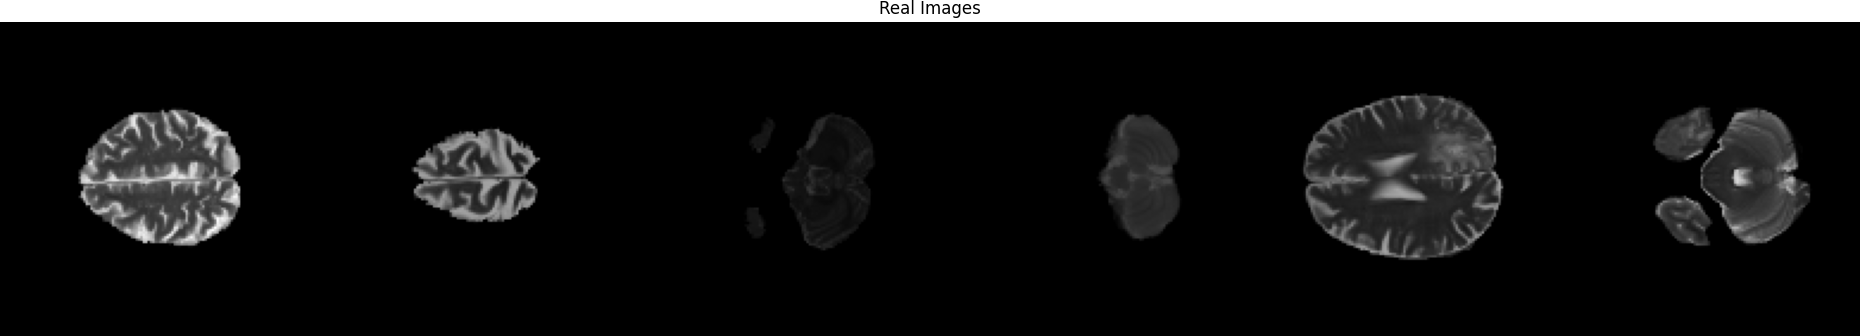

In [ ]:
real_image

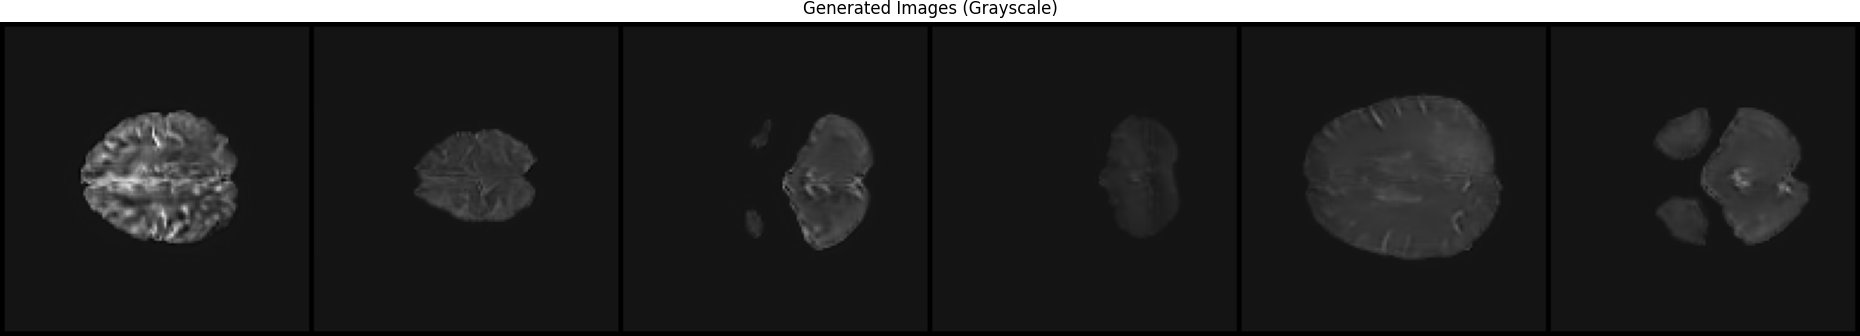

In [ ]:
generated_image